In [83]:
from numpy import cos, sin
from matplotlib import pyplot as plt
import numpy as np

In [84]:
def get_velocity(noise_strength, velocity):
    # add some noise if you want
    noise = np.random.normal(0, noise_strength, 2)

    return [velocity[0]+noise[0], velocity[1]+noise[1]]

def kinematic_model(state, v_l, v_r, axisLength):
    # equation for kinematic model
    # update real state of the robot
    state[0] += 0.5 * cos(state[2]) * v_l + 0.5 * cos(state[2]) * v_r
    state[1] += 0.5 * sin(state[2]) * v_l + 0.5 * sin(state[2]) * v_r
    state[2] += (v_r - v_l) / axisLength
    # return state of the robot
    return state

def odometry_sensor(state_1, state_2, estimate, noise_strength):
    noise = np.random.normal(0, noise_strength, 3)
    return [estimate[0] + state_2[0] - state_1[0] + noise[0], estimate[1] + state_2[1] - state_1[1] + noise[1], estimate[2] + state_2[2] - state_1[2] + noise[2]]

def simulate(noise_velocity = 0, noise_odometry = 0, velocity = [1.0, 1.0], drive_in_circles = False, axis_length = 1, steps = 1000, episodes = 100):
    # for visualization purposes
    x_errors, y_errors = [], []
    all_true_trajectories = []
    all_estimated_trajectories = []
    original_velocity = velocity.copy()
    if drive_in_circles:
        velocity = [velocity[0], velocity[1]*0.5]
    for _ in range(episodes):
        # states represent position and heading
        estimated_state = [0.0, 0.0, 0.0]
        optimal_state = [0.0, 0.0, 0.0]
        true_traj = [optimal_state[:2]]
        est_traj = [estimated_state[:2]]
        velocity = original_velocity.copy()
        for _ in range(steps):
            velocity = get_velocity(noise_velocity, velocity)
            previous_optimal_state = optimal_state.copy()
            optimal_state = kinematic_model(optimal_state, velocity[0], velocity[1], axis_length)
            estimated_state = odometry_sensor(previous_optimal_state, optimal_state, estimated_state, noise_odometry)
            true_traj.append(optimal_state[:2])
            est_traj.append(estimated_state[:2])
        x_errors.append(abs(round(estimated_state[0], 5) - round(optimal_state[0], 5)))
        y_errors.append(abs(round(estimated_state[1], 5) - round(optimal_state[1], 5)))
        all_true_trajectories.append(true_traj)
        all_estimated_trajectories.append(est_traj)
    return x_errors, y_errors, all_true_trajectories, all_estimated_trajectories
def plot_trajectories(true_trajs, est_trajs):
    plt.figure(figsize=(10, 10))
    for i in range(len(true_trajs)):
        true = np.array(true_trajs[i])
        est = np.array(est_trajs[i])
        plt.plot(true[:, 0], true[:, 1], label=f'True Traj {i+1}', linestyle='-', alpha=0.6)
        plt.plot(est[:, 0], est[:, 1], label=f'Est Traj {i+1}', linestyle='--', alpha=0.6)
        plt.scatter(true[0, 0], true[0, 1], color='black', marker='o')  # Start point
    plt.title("True vs Estimated Trajectories")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis('equal')
    # plt.legend()
    plt.grid(True)
    plt.show()

In [85]:
def plot_final_position_histogram(x_errors, y_errors):
    plt.figure(figsize=(6, 6))
    plt.hist2d(x_errors, y_errors, bins=30, cmap='Blues')
    plt.xlabel("X error")
    plt.ylabel("Y error")
    plt.title("Histogram of Final Position Error")
    plt.colorbar(label='Frequency')
    plt.grid(True)
    plt.show()


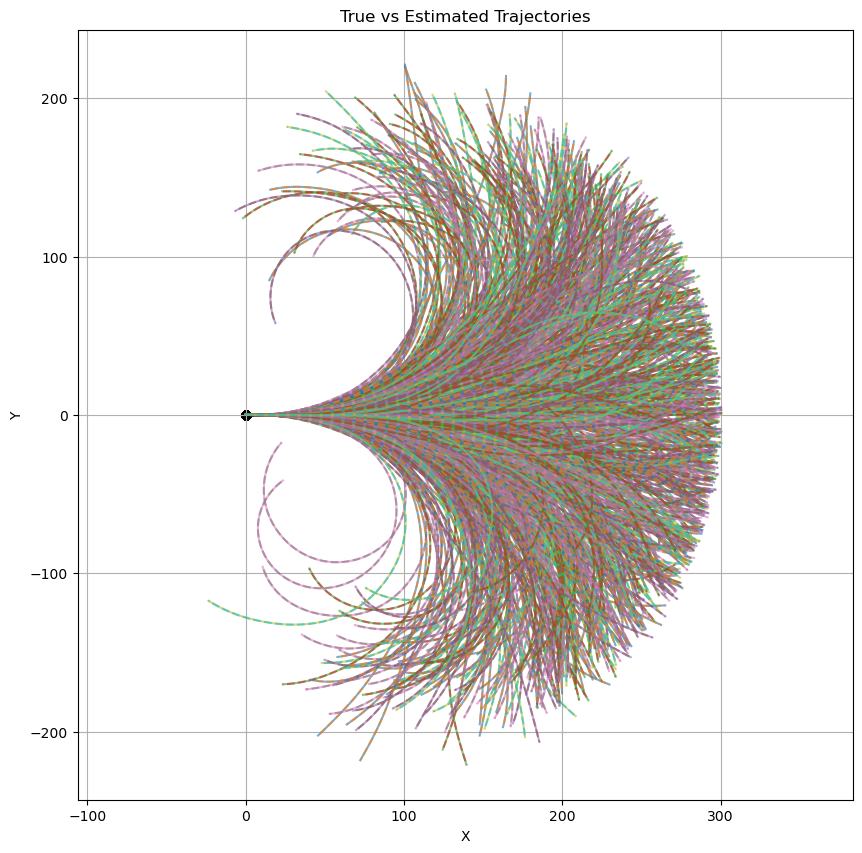

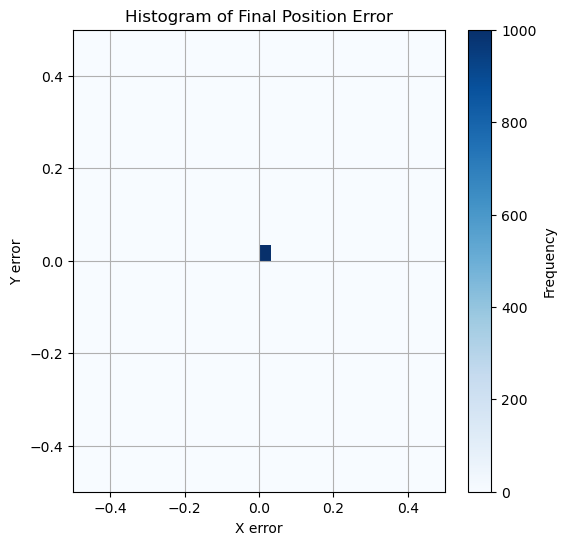

In [93]:
x_err, y_err, true_trajs, est_trajs = simulate(
    noise_velocity=4*10e-5,
    noise_odometry=0,
    drive_in_circles=False,
    episodes=1000,
    steps=300
)

plot_trajectories(true_trajs, est_trajs)
plot_final_position_histogram(x_err, y_err)

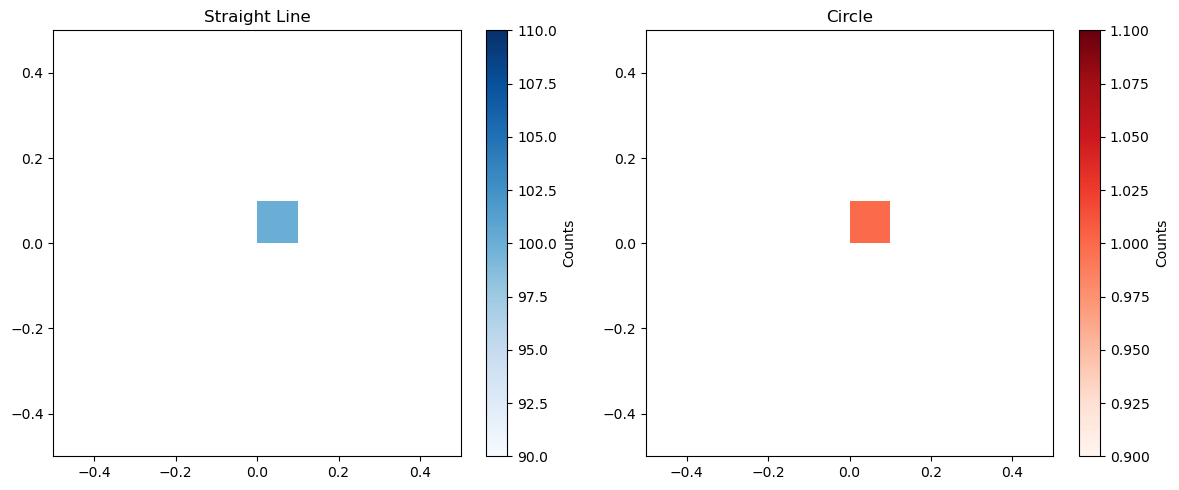

In [87]:
x_straight, y_straight, _, _ = simulate(noise_velocity=.005, noise_odometry=0)
x_circle, y_circle, _, _ = simulate(0, 0, drive_in_circles=True, steps=100000, episodes=1)

H1, xEdges1, yEdges1 = np.histogram2d(x_straight, y_straight, bins=10)
H2, xEdges2, yEdges2 = np.histogram2d(x_circle, y_circle, bins=10)
H1 = np.flipud(np.rot90(H1))
H2 = np.flipud(np.rot90(H2))
H1_masked = np.ma.masked_where(H1 == 0, H1)
H2_masked = np.ma.masked_where(H2 == 0, H2)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Straight Line")
plt.pcolormesh(xEdges1, yEdges1, H1_masked, cmap='Blues', shading='auto')
plt.colorbar(label='Counts')

plt.subplot(1, 2, 2)
plt.title("Circle")
plt.pcolormesh(xEdges2, yEdges2, H2_masked, cmap='Reds', shading='auto')
plt.colorbar(label='Counts')

plt.tight_layout()
plt.show()